This tutorial is based on the textbook here: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_2/glm_part1_estimation.html

# The GLM, part 1: estimation - SIGRID
This tutorial will be all about how most univariate fMRI analyses are done: using the **GLM**. Specifically, we'll focus on the "estimation" part of the GLM (i.e., how do we estimate parameters?).

The GLM, or the General Linear Model, is a statistical model that underlies a range of statistical models that you're probably already familiar with: (M)ANOVA, *t*-test, *F*-test, and most importantly ordinary *linear regression*. Mathematically, all these different tests are specific instantiations of the GLM (check [this blog post](https://lindeloev.github.io/tests-as-linear/) if you want to know more about this equivalence).

Basically, the type of fMRI analysis you are going to learn in this course (often called 'univariate analysis' or 'Statistical Parametric Mapping') is just an linear regression model applied to time-series data. Given that you have some basic familiarity with these concepts (we which recap in section 1), you will see during this tutorial that univariate fMRI analyses using the GLM are actually very straightforward.

As a consequence of the importance of the GLM, this week's lab is probably going to take quite long again. So, you'll have to work hard this week, but it'll definitely pay off. Also, the material will seem quite mathematical, but it often serves a symbolic purpose: to show you how results are influenced by different parts of the formulas within the GLM. Moreover, after showing and explaining you the formulas, we'll work it out in code examples (which are often easier to understand!). Also, after explaining a certain aspect of the GLM, we'll ask you to think about it and practice with it in ToThink and ToDo questions (like last week).

**What you'll learn**: after this tutorial ... 
* you know how to estimate and interpret parameters in a GLM and evaluate its model fit;
* you understand the importance of incorporating knowledge from the BOLD-response in the GLM;
* you are able to implement and apply the GLM to (univariate) fMRI data;
 <br>

## Recap of linear regression
To refresh your memory on linear regression, we'll walk you through a recap of the technique's most important concepts.
We are going to work through a simple example. 

In the code below, `y` will denote our *dependent variable* (the variable we try to model/explain) and `X` will denote our *independent variable(s)* (the variables we're using to try to explain `y`). Throughout the entire tutorial will use `X` to refer to our matrix of independent variables (also called "predictors" or "regressors", or simply "design matrix") and use `y` to refer to our dependent variable (also sometimes called "target").

Moreover, the independent variables are often grouped in a single matrix (a 2D array) &mdash; which is sometimes called the "design matrix" (because it 'designs' the way we want to model our dependent variable). As stated before, in this tutorial we store our design matrix - the set of our independent variables - in the variable `X` (or slight variations on that, like `X_new` or something). Importantly, it is often assumed (e.g. by statistics functions/software) that the design matrix takes the shape of $N\ \mathrm{(observations)} \times P\ \mathrm{(predictors)}$. So, the rows refer to the sampled observations (also often called "samples", "instances", or simply "data points"). The columns refer to the separate independent variables that we use to model the dependent variable. For the dependent variable, it is often assumed that this is a single row-vector of shape $N \times 1$.

### Notation
Next, let's define some more conventions in notation. We will denote the total number of observations with **$N$**. Moreover, we'll denote **$i$** as the index of samples. To give an example, the formula below gives you the sum of our target variable:

\begin{align}
\mathrm{sum}(\mathbf{y}) = \sum_{i=1}^{N} y_{i} 
\end{align}

Lastly, we denote the total number of predictors **$P$** and  **$j$** as the index of our predictors. So, for example, if we wanted to sum over our predictors for a given sample **$i$**, we'd write: 

\begin{align}
\mathrm{sum}(\mathbf{X}_{i}) = \sum_{j=1}^{P} \mathbf{X}_{ij} 
\end{align}

To practice with this notation, let's do a ToDo!

In [1]:
# First some imports
# importing modules
import os
import pip
os.system('python3 -m pip install numpy')
os.system('python3 -m pip install matplotlib')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


<div class='alert alert-warning'>
    <b>ToDo1</b>:
Try to see if you can do the following (solutions at the end of the notebook): 

1) Create a variable <tt>arr</tt> below (an array of shape $100 \times 25$), 

2) calculate the mean over all samples ($N$) for the predictor at index $j = 4$ (i.e., the fourth predictor). 

3) Store the result in a variable named <tt>mean_predictor_4</tt>.

How could it be done? Remember: Python has 0-based indexing!
</div>

In [2]:
""" Implement the ToDo1 below. """

np.random.seed(42)
arr = np.random.normal(0, 1, size=(100, 25))
# Implement your ToDo here

mean_predictor_4 = arr[:,3].mean()
print(mean_predictor_4)

0.08591373616660723


### Regression

Now, let's look at an example. Throughout the example below, we will gradually explain the components of linear regression. For the example, we will use randomly generated data to create a dependent variable with 30 observations ("samples"; $N = 30$) and a single independent variable ($P = 1$) with, of course, also 30 observations. So both the independent and dependent variable are of shape $30 \times 1$. Alright, let's get started!

For our example let's create some randomly generated data. As discussed, we'll create two variables (of shape $30\times 1$), which have a prespecified correlation of 0.8 (normally, you don't know this before doing the analysis of course, but we specify it here for the sake of the example). 

We'll denote our independent variable `X` and our dependent variable `y`.

In [3]:
np.random.seed(1)

#Create a covariance matrix for the two variables. The off-diagonals specify the covariance between variables (0.8)
prespecified_covariance = np.array([[1, .8],
                                    [.8, 1]])

#Create normally distributed data with the specified covariance
data = np.random.multivariate_normal(mean=[3, 7], cov=prespecified_covariance, size=30)

""" By default, when you slice out a single column (or row), numpy returns
an array of shape (some_number,) instead of (some_number, 1). However, for our
examples, we often actually want shape (some_number, 1) so essentially we want to 
"add" an extra axis. This is done by the np.newaxis command. Mess around with
it yourself to see how it works! """

X = data[:, 0, np.newaxis] # Here, we slice the first column (0) and immediately add a new axis!
y = data[:, 1, np.newaxis] # same here

print('The shape of X is: %s' % (X.shape,))
print('The shape of y is: %s' % (y.shape,))

The shape of X is: (30, 1)
The shape of y is: (30, 1)


Let's have a look at the data.

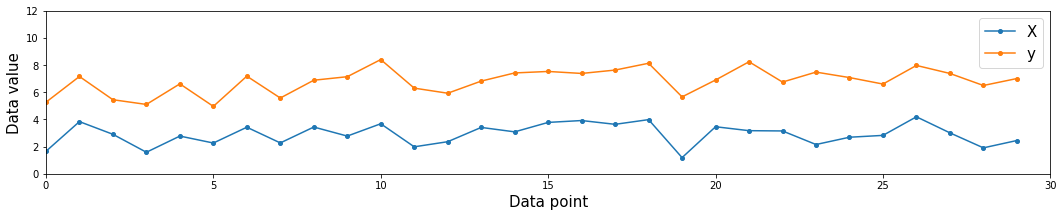

In [4]:
plt.figure(figsize=(18, 3))
plt.plot(X, 'o-', ms=4)
plt.plot(y, 'o-', ms=4)
plt.xlim(-1, data.size)
plt.ylim(0, 12)
plt.xlim(0, 30)
plt.ylabel('Data value', fontsize=15)
plt.xlabel('Data point', fontsize=15)
plt.legend(['X', 'y'], fontsize=15, loc='upper right', frameon=True)
plt.show()

The variable y will be our dependent variable and X will be our independent variable (a.k.a. predictor variable). The independent variable forms part of the design matrix (also called X), which we will use to predict the dependent variable.

### Modeling the intercept (offset)
As you probably were told in your previous statistics classes, you should always "model the intercept" when running any (regression) model. Technically, the intercept models some of the signal using a constant term. The parameter corresponding to the intercept (as calculated by the linear regression model), then, refers to *the average value of your $y$ variable when all predictors in $X$ are 0*. So, conceptually, the intercept models the mean when of the dependent variable when controlling for our (other) predictors.

To "model the intercept", you should add an extra "constant predictor" to your design matrix (`X`). This "constant predictor" means simply an array of shape $N \times 1$ with a constant value, usually all ones. (You'll figure out *why* you should do this later in the tutorial.)

Remember from week 1 how to create an array with ones? We can just use `np.ones(shape_of_desired_array)`!

In [5]:
n_obs = y.size
intercept = np.ones((n_obs, 1))  # creates intercept of shape (N, 1)

Now, we want to add it to our design matrix (`X`). We can do this using the numpy function `np.hstack` (which is short for "horizontal stack", i.e. "stacking columns horizontally"). This function takes a tuple with arrays which show have the same amount of rows (for our data: both have 30 rows) and returns the a new array in which the arrays from the tuple are stacked (stacked shape should be $30 \times 2$):

In [6]:
tuple_with_arrays = (intercept, X)
X_with_icept = np.hstack(tuple_with_arrays)

# Note: you could also simply do ...
# X_with_icept = np.hstack((np.ones((y.size, 1)), X))
# ... but arguably this is less 'readable' than the implementation above
print("Shape of X is now: %s" % (X_with_icept.shape,))

Shape of X is now: (30, 2)


Let's take a look at the X matrix ("design matrix") we have now. As you'll see, we have two columns: the first one is our intercept-predictor, and the second one is our 'regular' predictor.

In [7]:
print(X_with_icept)

[[1.         1.65246505]
 [1.         3.84037019]
 [1.         2.90681268]
 [1.         1.58544098]
 [1.         2.77619077]
 [1.         2.26439631]
 [1.         3.42732047]
 [1.         2.27222802]
 [1.         3.44118297]
 [1.         2.77565017]
 [1.         3.68214561]
 [1.         1.98577328]
 [1.         2.36158674]
 [1.         3.41250018]
 [1.         3.08642782]
 [1.         3.78163148]
 [1.         3.91918676]
 [1.         3.64080489]
 [1.         3.98584491]
 [1.         1.19071843]
 [1.         3.46268411]
 [1.         3.17361546]
 [1.         3.15323524]
 [1.         2.15472268]
 [1.         2.69083045]
 [1.         2.82662461]
 [1.         4.1943598 ]
 [1.         3.01266793]
 [1.         1.90963012]
 [1.         2.44916186]]


Now, let's take a look at the data. We'll create a scatter-plot for this (we'll leave out the intercept).  Note how correlated the two variables are.

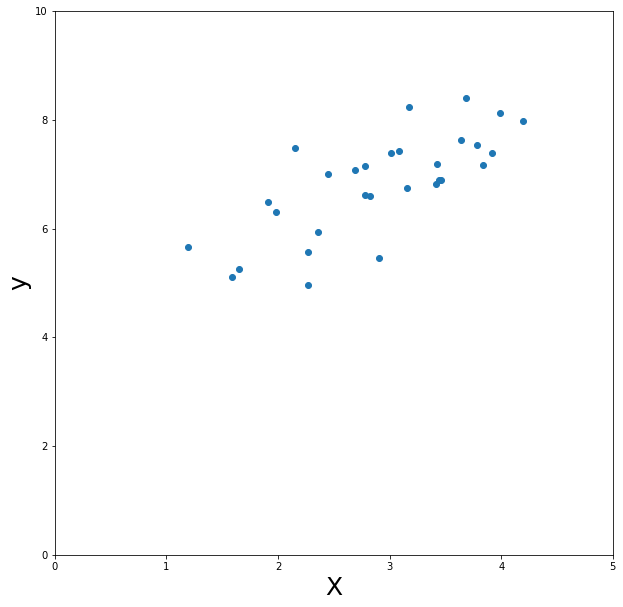

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(X_with_icept[:, 1], y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
plt.show()

### Parameters in linear regression
As you can see, there seems to be some positive linear relationship between $X$ (just the independent variable without the intercept) and $y$. In other words, an increase in $X$ will lead to an increase in $y$. But, at this moment, *how much exactly* $y$ changes for a increase in $X$ is unknown. By doing a linear regression with $X$ as our predictor of $y$, we can quantify this! 

The parameter, i.e. the "thing" that quantifies the influence of $X$ on $y$, calculated by this model is often called the **beta-parameter(s)** (but sometimes they're denoted as theta, or any other greek symbol/letter). The beta-parameter quantifies exactly how much $y$ changes if you increase $X$ by 1. Or, in other words, it quantifies how much influence $X$ has on $y$. In a formula ($\delta$ stands for "change in")\*: 

\begin{align}
\beta_{j} = \frac{\delta y}{\delta X_{j}} 
\end{align}

As you probably realize, each predictor in $X$ (i.e., $X_{j}$) has a parameter ($\beta_{j}$) that quantifies how much influence that predictor has on our target variable ($y$). This includes the intercept, our vector of ones (which is in textbooks often denoted by $\beta_{0}$; they often don't write out $\beta_{0}X_{0}$ because, if a vector of ones is used, $\beta_{0}\cdot 1$ simplifies to $\beta_{0}$).

Thus, linear regression describes a model in which a set of beta-parameters are calculated to characterize the influence of each predictor in $X$ on $y$, that together explain $y$ as well as possible (but the model is usually not perfect, so there will be some *error*, or "unexplained variance", denoted by $\epsilon$). As such, we can formulate the linear regression model as follows:

\begin{align}
y = \beta_{0} + X_{1}\beta_{1} + X_{2}\beta_{2} ... + X_{P}\beta_{P} + \epsilon
\end{align}

which is often written out as (and is equivalent to the formula above):

\begin{align}
y = \sum_{j=1}^{P}X_{j}\beta_{j} + \epsilon
\end{align}

Here, $\epsilon$ is the variance of $y$ that cannot be explained by our predictors (i.e, the *error*). 

But how does linear regression estimate the beta-parameters? The method most often used is called **'ordinary least squares'** (OLS; or just 'least squares'). This method tries to find a "weight(s)" for the independent variable(s) such that when you multiply the weight(s) with the independent variable(s), it produces an estimate of $y$ (often denoted as $\hat{y}$, or "y-hat") that is as 'close' to the true $y$ as possible. In other words, least squares tries to 'choose' the beta-parameter(s) ($\hat{\beta}$) such that the difference between $X$ multiplied with the beta(s) (i.e. our best guess of $y$, denoted as $\hat{y}$) and the true $y$ is minimized\*. 

Let's just formalize this formula for the 'best estimate of $y$' (i.e. $\hat{y}$):

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

Before we're going into the estimation of these beta-parameters, let's practice with calculating $\hat{y}$!

<div class='alert alert-warning'>
    <b>ToDo2</b>: Below, we've defined a design matrix with two predictors (<tt>this_X</tt>) and an array with beta-estimates (<tt>these_betas</tt>; just pretend that these betas were estimated by us beforehand). Now, given this data, can you calculate the predicted $y$-values (i.e., $\hat{y}$)? Store these predicted $y$-values in an array named <tt>this_y_hat</tt>.

Hint: your <tt>this_y_hat</tt> array should be of shape <tt>(100,)</tt>.
</div>

In [9]:
# Just generate some random normal data with mean 0, std 1, and shape 100x2 (NxP)
this_X = np.random.normal(0, 1, (100, 2))
these_betas = np.array([5, 3])

#IMPLEMENT YOUR SOLUTION HERE (if you get stuck, look at the end of the notebook):

this_y_hat = this_X @ these_betas 
print(this_y_hat)


[ -0.01338524   1.6703706    2.21587559  10.21759739   6.73838803
  -8.73396662   3.42869211  -4.48842891   0.95290386   3.43650722
  -1.71391492   2.1629619    1.34852454  -2.22062007   3.99755808
   6.55005865  -3.79261597   2.34949198  -1.58847781  -1.00590812
   1.43788029   3.79819378  -4.96641193   0.84168045  -1.23324889
  -5.92010843   1.65225542  -2.18412034  -5.04079461   6.83379015
  -2.44856964  12.2700849   -5.58141723   9.15228886  -3.40630421
  -2.71636339  -4.49867819   2.09344214  -0.83014248   4.14900705
  -1.23808648   6.5956657    3.06043025   2.24424643   3.21012702
  -8.85509716  11.75506195   1.90635652  -1.03938628  -3.27900914
  -5.57655277   0.35407235   1.95194714   5.57227764   5.26441588
  -0.53012277  11.8957242   -0.46059776   5.79536197   2.4409444
  -5.42215061   6.39560171  -2.40432132   3.53601676   1.18398727
   6.910171    12.85646364  -1.58706604   4.27244301   7.18808465
   0.4676259    3.05310707 -11.94182401 -10.92527308   0.27265972
  -5.660524

### Refresher: matrix multiplication
In the GLM (and statistics in general), you'll very likely come across concepts and operations from linear (matrix) algebra, such as matrix multiplication and the matrix inverse. In week 1, we briefly discussed how matrix/vector multiplication can be done with Python/numpy: using the `.dot` numpy attribute or with the `@` operator. In this course, you'll encounter several matrix operations as part of the GLM. In fact, we can implement the operation from the previous ToDo (calculating $\hat{y}$) using matrix multiplication as well.

See the figure below for a visual explanation of matrix multiplication:
![dot_prod](https://hadrienj.github.io/assets/images/2.2/dot-product.png)
*Image by Hadrien Jean ([link](https://hadrienj.github.io/assets/images/2.2/dot-product.png))*

If your understanding of matrix algebra, and especially matrix multiplication, is still somewhat rusty, check out [this video](https://www.youtube.com/watch?v=fkZj8QoYjq8) by Jeanette Mumford. Now, suppose that the left matrix in the above figure represents our matrix $\mathbf{X}$ and that the right vector represents our estimated parameters $\hat{\beta}$. Now, we can calculate $\hat{y}$ as the matrix operator $X\hat{\beta}$:

\begin{align}
\hat{y} = 
  \begin{bmatrix}
    X_{1,1} & X_{1,2} \\
    X_{2, 1} & X_{2, 2} \\
    \vdots & \vdots \\
    X_{N, 1} & X_{N, 2}
  \end{bmatrix} 
  \begin{bmatrix}
    \hat{\beta}_{1} \\
    \hat{\beta}_{2}
  \end{bmatrix}
\end{align}

Let's check this in code:

In [10]:
this_y_hat_dot = this_X @ these_betas  # this_X.dot(these_betas) is also correct
print(this_y_hat_dot)

[ -0.01338524   1.6703706    2.21587559  10.21759739   6.73838803
  -8.73396662   3.42869211  -4.48842891   0.95290386   3.43650722
  -1.71391492   2.1629619    1.34852454  -2.22062007   3.99755808
   6.55005865  -3.79261597   2.34949198  -1.58847781  -1.00590812
   1.43788029   3.79819378  -4.96641193   0.84168045  -1.23324889
  -5.92010843   1.65225542  -2.18412034  -5.04079461   6.83379015
  -2.44856964  12.2700849   -5.58141723   9.15228886  -3.40630421
  -2.71636339  -4.49867819   2.09344214  -0.83014248   4.14900705
  -1.23808648   6.5956657    3.06043025   2.24424643   3.21012702
  -8.85509716  11.75506195   1.90635652  -1.03938628  -3.27900914
  -5.57655277   0.35407235   1.95194714   5.57227764   5.26441588
  -0.53012277  11.8957242   -0.46059776   5.79536197   2.4409444
  -5.42215061   6.39560171  -2.40432132   3.53601676   1.18398727
   6.910171    12.85646364  -1.58706604   4.27244301   7.18808465
   0.4676259    3.05310707 -11.94182401 -10.92527308   0.27265972
  -5.660524

In other words, the non-matrix algebra notation ...

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

... is exactly the same as the the following matrix algebra notation:

\begin{align}
\hat{y}_{i} = \mathbf{X}_{i}\mathbf{\hat{\beta}} 
\end{align}

You can usually recognize the implementations in formulas using algebra by the use of bold variables (such as $\mathbf{X}$, which denote matrices) here above.

*You will calculate `y_hat` quite a lot throughout this lab; please use the matrix algebra method to calculate `y_hat`, because this will likely prevent errors in the future!* So, use this ...

```python
y_hat = X @ betas
```

instead of ...

```python
y_hat = X[:, 0] * betas[0] + X[:, 1] * betas[1]
```

### Fitting OLS models
Thus far, we've ignored how OLS actually calculates (or "fits") the unknown parameters $\beta$. Roughly speaking, OLS finds parameters that minimize the *sum of squared errors* (hence the name '[ordinary] least squares'!):

\begin{align}
\min_{\beta} \sum_{i=1}^{N}(y_{i} - X_{i}\hat{\beta})^2 
\end{align}

This formula basically formalizes the approach of OLS "find the beta(s) that minimize the difference of my prediction of $y$ (calculated as $X \cdot \beta$) and the true $y$". Now, this still begs the question, *how does OLS estimate these parameters?* It turns out there is an "analytical solution" to this problem, i.e., there is a way to compute beta estimates that are guaranteed (given some assumptions) to give the parameters that minimize the summed squared error. This solution involves a little matrix algebra and is usually formulated as a series of matrix operations:

\begin{align}
\hat{\beta} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}y
\end{align}

(For the mathematically inclined, see [this](https://economictheoryblog.com/2015/02/19/ols_estimator/) or [this](https://socialstatisticsfun.wordpress.com/2012/12/18/deriving-the-ols-estimator-continued/) blog for the derivation of the OLS solution.) In this formula, $\mathbf{X}^{T}$ refers to the transpose of the design matrix $\mathbf{X}$.

We don't expect you to understand every aspect of this formula, but you should understand the objective of least squares (minimizing the difference between $\hat{y}$ and true $y$) and what role the beta-parameters play in this process (i.e. a kind of weighting factor of the predictors).

Let's look at how we'd implement the OLS solution in code. We'll use the `@` operator for matrix multiplication and the `inv` function from the `numpy.linalg` module for the matrix inversion (i.e., the $(X^{T}X)^{-1}$ part).

In [11]:
from numpy.linalg import inv

est_betas = inv(X_with_icept.T @ X_with_icept) @ X_with_icept.T @ y

print("Shape of estimated betas: %s" % (est_betas.shape,))
print(est_betas)

Shape of estimated betas: (2, 1)
[[4.25897963]
 [0.88186203]]


"What? Why are there two beta-parameters?", you might think. This because you also use the intercept as a predictor, which also has an associated beta-value (weighting factor). Here, the first beta refers to the intercept of the model (because it's the first column in the design-matrix)! The second beta refers to our 'original' predictor. Thus, the model found by least squares for our generated data is (i.e. that leads to our best estimate of $y$, i.e. $\hat{y}$:

\begin{align}
\hat{y} = X_{1} \cdot 4.259 + X_{2} \cdot 0.882 
\end{align}

And since our intercept (here $X_{1}$) is a vector of ones, the formula simplifies to:

\begin{align}
\hat{y} = 4.259 + X_{2} \cdot 0.882
\end{align}

Now, let's calculate our predicted value of $y$ ($\hat{y}$) by implementing the above formula by multiplying our betas with the corresponding predictors (intercept and original predictor). Here, because we have two predictors, we simply add the two "`predictor * beta`" terms to get the final $\hat{y}$.

In [12]:
y_hat = X_with_icept[:, 0] * est_betas[0] + X_with_icept[:, 1] * est_betas[1]
print('The predicted y-values are: \n\n%r' % y_hat)

The predicted y-values are: 

array([5.7162258 , 7.64565627, 6.82238735, 5.65711982, 6.70719685,
       6.25586475, 7.2814034 , 6.26277124, 7.29362822, 6.70672011,
       7.50612402, 6.01015768, 6.3415733 , 7.26833396, 6.98078313,
       7.59385684, 7.71516161, 7.46966721, 7.77394491, 5.30902899,
       7.31258926, 7.05767059, 7.03969805, 6.15914774, 6.63192082,
       6.75167254, 7.95782627, 6.91573708, 5.94300991, 6.41880247])


Now, let's plot the predicted $y$ values ($\hat{y}$) against the true $y$ values ($y$).

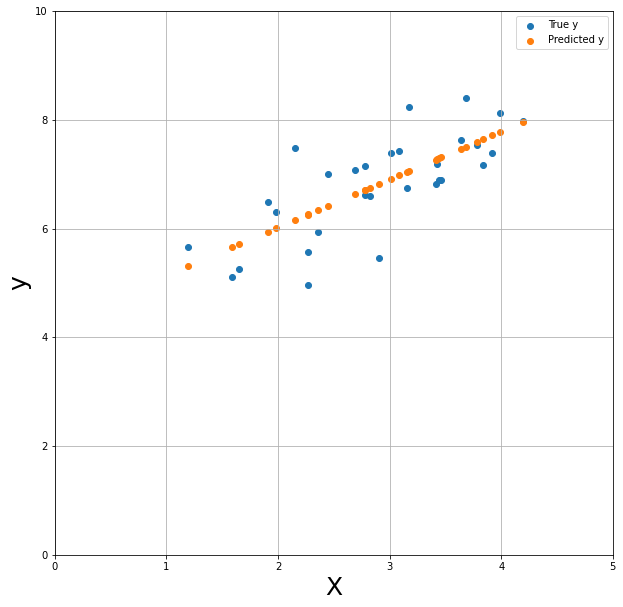

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
x_lim = (0, 5)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_hat = X_with_icept @ est_betas # using the matrix algebra approach!
plt.scatter(X, y_hat, c='tab:orange')
plt.legend(['True y', 'Predicted y'])
plt.grid()
plt.show()

Actually, let's just plot the predicted y-values as a line (effectively interpolating between adjacent predictions) - this gives us the linear regression plot as you've probably seen many times in your statistics classes!

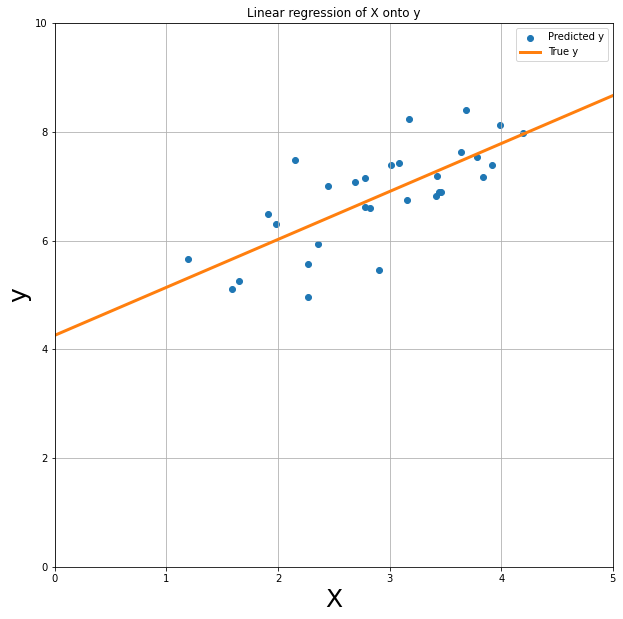

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = est_betas[0] + est_betas[1] * x_lim[0]
y_max_pred = est_betas[0] + est_betas[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='tab:orange', lw=3)
plt.legend(['Predicted y', 'True y'])
plt.title('Linear regression of X onto y')
plt.grid()
plt.show()

### Residuals and model fit
Alright, so now we have established the beta-values that lead to the best prediction of $y$ - in other words, the best fit of our model. But how do we quantify the fit of our model? One way is to look at the difference between $\hat{y}$ and y, which is often referred to as the model's **residuals**. This difference between $\hat{y}$ and $y$ - the residuals - is the exact same thing as the $\epsilon$ in the linear regression model, i.e. the **error** of the model. Thus, for a particular dependent variable $y$, the residuals ($\epsilon$) of a particular fitted model with parameters $\hat{\beta}$ are computed as: 

\begin{align}
\epsilon = y - \mathbf{X}\hat{\beta} 
\end{align}

To visualize the residuals (plotted as red dashed lines):

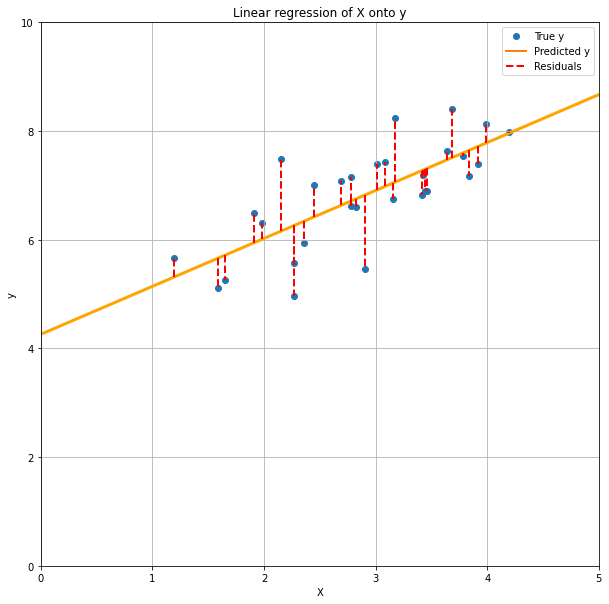

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = est_betas[0] + est_betas[1] * x_lim[0]
y_max_pred = est_betas[0] + est_betas[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange', lw=3)
plt.title('Linear regression of X onto y')

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat[i], y[i]), linestyle='--', c='red', lw=2)


from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='tab:blue', marker='o', ls='None', lw=2),
    Line2D([0], [0], color='tab:orange', lw=2),
    Line2D([0], [0], color='r', ls='--', lw=2)
]

plt.legend(custom_lines, ['True y', 'Predicted y', 'Residuals'])
plt.grid()
plt.show()

In fact, the model fit is often summarized as the **mean of the squared residuals** (also called the 'mean squared error' or MSE), which is thus simply the (length of the) red lines squared and averaged. In other words, the MSE refers to the average squared difference between our predicted $y$ and the true $y$\*:

\begin{align}
\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2
\end{align}

\* The "$\frac{1}{N}\sum_{i=1}^{N}$" is just a different (but equally correct) way of writing "the average of all residuals from sample 1 to sample N".

<div class='alert alert-warning'>
    <b>ToDo3</b>: Calculate the MSE for our previous model predictions (<tt>y_hat</tt>) based on our linear regression model predicting <tt>y</tt> from <tt>X_with_intercept</tt>. <em>Do not use a for-loop for this.</em> You know how to do this without a loop, using vectorized numpy array operations. Store the result in a variable named <tt>mse</tt>. (Solution at the end of the notebook).
</div>

In [19]:

# INSERT SOLUTION FOR ToDo3 HERE


#We will reuse the variable name y later, so in if you need to go to the solutions section, we will rename the variable name
y_old=y.copy()

mse = ((y_old-y_hat)**2).mean()
print(mse)
# in the solutions they use np.mean()

0.3837095525610668


Another metric for model fit in linear regression is "R-squared" ($R²$). R-squared is calculated as follows:

\begin{align}
R^2 = 1 - \frac{\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^2}{\sum_{i=1}^{N}(y_{i} - \bar{y})^2}
\end{align}

where $\bar{y}$ represents the mean of $y$. As you can see, the formula for R-squared consists of two parts: the numerator ($\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^2$) and the denominator ($\sum_{i=1}^{N}(y_{i} - \bar{y}_{i})^2$). The denominator represents the *total* amount of squared error of the actual values ($y$) relative to the mean ($\bar{y}$). The numerator represents the *reduced* squared errors when incorporating knowledge from our (weighted) independent variables ($X_{i}\hat{\beta}$). So, in a way you can interpret R-squared as *how much better my model is including `X` versus a model that only uses the mean*. Another conventional interpretation of R-squared is the proportion of variance our predictors ($X$) together can explain of our target ($y$).

As expected, the code is quite straightforward:

In [17]:

#Calculate the residual sum of squares (difference from predicted value)
RSS = np.sum((y - y_hat) ** 2)  # remember, y_hat equals X * beta
#Calculate the total sum of squares (difference from mean)
TSS = np.sum((y - np.mean(y)) ** 2)
# R-squared is the proportion of the variance explained by the model (i.e. 1 minus the variance not explained)
r_squared = 1 - RSS / TSS

print('The R² value is: %.3f' % r_squared)

The R² value is: 0.549


<div class='alert alert-warning'>
    <b>ToDo4</b>: Below, we've defined a design matrix (<tt>X_test</tt>, including an intercept) and a dependent variable (<tt>y_test</tt>). Run a linear regression model and calculate R-squared. Store the R-squared value (which should be a single number, a float) in a variable named <tt>r_squared_test</tt>.
</div>

In [45]:
#Load data
data_tmp = np.load('data/data_todo_rsquared.npz')
X_test, y_test = data_tmp['X'], data_tmp['y']

### INSERT SOLUTION HERE (see end of notebook)
# estimate betas
b_test = inv(X_test.T @ X_test) @ X_test.T @ y_test

# calculate y hat
y_hat_test = X_test @ b_test

# calculate R-squared
# residual sum of squares
rss_test = np.sum((y_test - y_hat_test) **2)

# total sum om squares
tss_test = np.sum((y_test - np.mean(y_test))**2)

# R-squared
r_sq_test = 1 - rss_test/tss_test

print('The R^2 value is: %3f' % r_sq_test)

The R^2 value is: 0.363245


<div class='alert alert-info'>
<b>ToThink1</b>: As discussed earlier, it's important to model the intercept in regression models. This is because it often greatly <em>improves model fit</em>! In this ToThink, you have to explain <em>why</em> modelling the intercept (usually) improves model fit. 

To give you some clues, we re-did the linear regression computation from above, but now without the intercept in the design matrix. We plotted the data (<tt>X_no_icept</tt>, <tt>y</tt>) and the model fit to get some intuition about the use of an intercept in models. 

In the text-cell below the plot, explain (concisely!) why modelling the intercept (usually) improves model fit (this is manually graded, so no test-cell). (see end of the notebook for an answer).
</div>

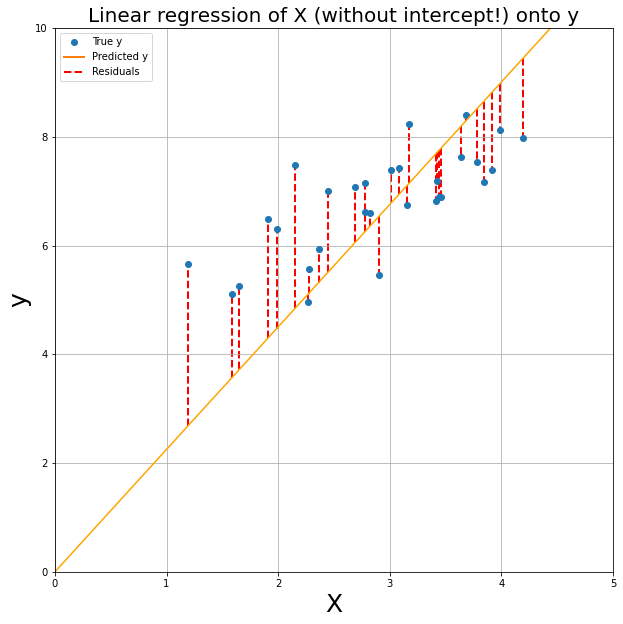

In [19]:
X_no_icept = X_with_icept[:, 1, np.newaxis]
beta_no_icept = inv(X_no_icept.T @ X_no_icept) @ X_no_icept.T @ y
y_hat_no_icept = beta_no_icept * X_no_icept

plt.figure(figsize=(10, 10))
plt.scatter(X, y, zorder=2)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
y_min_pred = beta_no_icept[0] * x_lim[0]
y_max_pred = beta_no_icept[0] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange')
plt.grid()
plt.title('Linear regression of X (without intercept!) onto y', fontsize=20)

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat_no_icept[i], y[i]), 'r--', lw=2, zorder=1)

plt.legend(custom_lines, ['True y', 'Predicted y', 'Residuals'])
plt.show()


Write your answer for ToThink1 here:

### Summary: linear regression
Alright, hopefully this short recap on linear regression has refreshed your knowledge and understanding of important concepts such as predictors/design matrix ($X$), target ($y$), least squares, beta-parameters, intercept, $\hat{y}$, residuals, MSE, and $R^2$. 

In sum, for a linear regression analysis you need some predictors ($X$) to model some target ($y$). You perform ordinary least squares to find the beta-parameters that minimize the sum of squared residuals. To assess model fit, you can look at the mean squared error (average mis-prediction) or $R^2$ (total explained variance).

If you understand the above sentence, you're good to go! Before we go on to the real interesting stuff (modelling fMRI data with linear regression), let's test how well you understand linear regression so far.

<div class='alert alert-warning'>
<b>ToDo5</b>:
    
Now, you're going to implement your own linear regression on a new set of variables, but with a twist: you're going to use 5 predictors this time - we've generated the data for you already. You'll notice that the code isn't much different from when you'd implement linear regression for just a single predictor (+ intercept). In the end, you should have calculated MSE and $R^2$, which should be stored in variables named <tt>mse_todo</tt> and <tt>r2_todo</tt> respectively.

*Note, though, that it **isn't** possible to plot the data (either X, y, or y_hat) because we have more than one predictor now; X is 5-dimensional (6-dimensional if you include the intercept) - and it's impossible to plot data in 5 dimensions!*

To give you some handles on how to approach the problem, you can follow these steps:

1. Check the shape of your data: is the shape of X <tt>(N, P)</tt>? is the shape of y <tt>(N, 1)</tt>?
2. Add an intercept to the model, use: <tt>np.hstack</tt>;
3. Calculate the beta-parameters using the formula you learned about earlier;
4. Evaluate the model fit by calculating the MSE and R-squared;
</div>

In [72]:
# Here, we load the data
data = np.load('data/ToDo.npz')
X, y = data['X'], data['y']

In [48]:
# 1. Check the shape of X and y

### BEGIN SOLUTION
X.shape
y.shape

(1000, 1)

In [53]:
# 2. Add the intercept (perhaps define N first, so that your code will be more clear?) using np.hstack()

### BEGIN SOLUTION
n_obs = y.size
intercept = np.ones((n_obs, 1))  # creates intercept of shape (N, 1)
tuple_with_arrays = (intercept, X)
X_with_int = np.hstack(tuple_with_arrays)

(1000, 6)

In [84]:
# 3. Calculate the betas using the formula you know

### BEGIN SOLUTION
betas = inv(X_with_int.T @ X_with_int) @ X_with_int.T @ y 

print(betas)

[[ 6.66694315]
 [-0.01159282]
 [-0.25573929]
 [ 0.47342146]
 [ 0.21746357]
 [ 0.12759367]]


In [86]:
# 4. Calculate the MSE (store it in a variable named mse_todo)

### BEGIN SOLUTION
# calculate y hat
y_hat = X_with_int @ betas

# mse
mse_todo = np.mean((y - y_hat)**2)
print("The MSE is: %3f" % mse_todo)


The MSE is: 0.656335


In [87]:
# 5. Calculate R-squared  (store it in a variable named r2_todo)

### BEGIN SOLUTION

# RSS
rss = np.sum((y-y_hat)**2)

# TSS
tss = np.sum((y-np.mean(y))**2)

r_sq = 1 - rss/tss

print("The R-squared is: %3f" % r_sq)

The R-squared is: 0.340934


<div class='alert alert-info'>
<b>ToThink2</b>: Let's check whether you understand what a particular beta-parameter means.

- Some of the betas are negative (i.e., $\hat{\beta}< 0$); what does this tell you about the effect of that particular condition/predictor? (.5 point; first text-cell)
- The intercept-parameter (i.e., $\beta_{0}$) should be about 6.6. What does this value tell us about the signal?

Write your answers in the text-cell below.
</div>

ToThink2:

If you've finished the ToDo exercise and you're confident that you understand linear regression, you're ready to start with the fun part: applying the GLM to fMRI data!

## SOLUTIONS

<div class='alert alert-warning'>
    <b>Solution for ToDo1</b>:
</div>

In [26]:
""" Solution for ToDo 1 below. """

# 1) create a variable
np.random.seed(42)
arr = np.random.normal(0, 1, size=(100, 25))

# 2+3) calculate mean and store with variable name
mean_predictor_4 = np.mean(arr[:, 3])
### END SOLUTION

<div class='alert alert-warning'>
    <b>Solution for ToDo2</b>:
</div>

In [27]:
# Just generate some random normal data with mean 0, std 1, and shape 100x2 (NxP)
this_X = np.random.normal(0, 1, (100, 2))
these_betas = np.array([5, 3])

#SOLUTION:
this_y_hat = this_X[:, 0] * these_betas[0] + this_X[:, 1] * these_betas[1]


<div class='alert alert-warning'>
    <b>Solution for ToDo3</b>:
</div>

In [21]:
""" Solution for ToDo 3 below. """

#This is the solution
#mse = np.mean((y - y_hat) ** 2)

#We have reused the variable name y, so in order for it to run here, we changed the variable name
mse = np.mean((y_old - y_hat) ** 2)
mse

0.3837095525610668

<div class='alert alert-warning'>
    <b>Solution for ToDo4</b>:
</div>

In [29]:
#Load data
data_tmp = np.load('data/data_todo_rsquared.npz')
X_test, y_test = data_tmp['X'], data_tmp['y']

### SOLUTION FOR ToDo4
b = inv(X_test.T @ X_test) @ X_test.T @ y_test
RSS = np.sum((y_test - X_test.dot(b)) ** 2)
TSS = np.sum((y_test - y_test.mean()) ** 2)
r_squared_test = 1 - (RSS / TSS)
print('The R² value is: %.3f' % r_squared_test)

The R² value is: 0.363


<div class='alert alert-warning'>
    <b>Solution for ToDo5</b>:
</div>

In [73]:
# Here, we load the data
data = np.load('data/ToDo.npz')
X, y = data['X'], data['y']

In [74]:
# 1. Check the shape of X and y

### BEGIN SOLUTION
print(X.shape)
print(y.shape)
### END SOLUTION

(1000, 5)
(1000, 1)


In [82]:
# 2. Add the intercept (perhaps define N first, so that your code will be more clear?) using np.hstack()

### BEGIN SOLUTION
X_new = np.hstack((np.ones((1000, 1)), X))
### END SOLUTION
print(X_new.shape)

(1000, 6)


In [83]:
# 3. Calculate the betas using the formula you know

### BEGIN SOLUTION
betas = inv(X_new.T @ X_new) @ X_new.T @ y
### END SOLUTION
print(betas)

[[ 6.66694315]
 [-0.01159282]
 [-0.25573929]
 [ 0.47342146]
 [ 0.21746357]
 [ 0.12759367]]


In [78]:
# 4. Calculate the MSE (store it in a variable named mse_todo)

### BEGIN SOLUTION
y_hat = X_new @ betas
mse_todo = np.mean((y - y_hat) ** 2)
print(mse_todo)
### END SOLUTION

0.65633474948831


In [79]:
# 5. Calculate R-squared  (store it in a variable named r2_todo)

### BEGIN SOLUTION
r2_todo = 1 - (np.sum((y_hat - y) ** 2) / np.sum((y.mean() - y) ** 2))
print('The R² value is: %.3f' % r2_todo)
### END SOLUTION

The R² value is: 0.341



A model without an intercept is "forced" to draw its line through the origin (0, 0), failing to explain much of the variance of targets (potential $y$ vectors) that have an offset/scale that is clearly far from 0 (which should be clear from the plot.)

<div class='alert alert-info'>
<b>Solution for ToThink2</b>: Let's check whether you understand what a particular beta-parameter means.

- Some of the betas are negative (i.e., $\hat{\beta}< 0$); what does this tell you about the effect of that particular condition/predictor? (.5 point; first text-cell)
- The intercept-parameter (i.e., $\beta_{0}$) should be about 6.6. What does this value tell us about the signal?

Write your answers in the two text-cells below.
</div>

Negative betas simply state that an increase in particular predictor leads to a decrease in the target (and vice versa).

The intercept-parameter represents the 'baseline' of the signal, i.e., the average activity when there's no event (stimulus). In other words, it represents the average activity of $y$ when all predictors are held constant ($X_{j} = 0$ for every predictor $j$).